# Выпускной проект: Предсказание оттока клиентов

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Цель проекта: разработать модель, которая сможет предсказать вероятность 

План проекта
 1. Предварительный осмотр и Исследовательский анализ данных
 
  Загрузка датасетов и получение первичной информации о них: Их объём, наполнение, распределение и количество пропусков. Проведение Исследовательского анализа, который заключается в поиске закономерностей между столбцами и их особенностей.
  
 2. Предобработка
 
   объедениние/удаление столбцов на основе ранее приведённого анализа. Создание единого датасета на основе четырех предосталенных.
   
 3. Создание модели
 
  Тестирование трёх моделей и их гиперпараметров, с целью поиска наиболее оптимального варианта.
  
 4. Финальная Проверка и вывод
 
  Проверка наилучшей модели на тестовой выборке, она должна иметь показатель AUC-ROC не ниже 85. Подведение вывода и итога       проекта.
  

Цели проекта будут достигнуты после создания модели, которая предскажет уход пользователя, с показателем AUC-ROC не ниже 85 на тестовой выборке

In [1]:
pip install scikit-learn==1.1.3

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install association-metrics

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install eli5

Note: you may need to restart the kernel to use updated packages.


In [4]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import association_metrics as am
import sklearn.metrics as metrics
import eli5

# импорты модулей текущего проекта
from eli5.sklearn import PermutationImportance
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import (
    GridSearchCV, 
    cross_validate,
    train_test_split,
    cross_val_score
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

# настройки
warnings.filterwarnings("ignore")


RANDOM_STATE = 120623

## Первичный осмотр

In [5]:
#Создаю функию для получения информации
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [6]:
#Загружаю датасеты
df_contract = pd.read_csv('/datasets/contract_new.csv')
df_personal = pd.read_csv('/datasets/personal_new.csv')
df_internet = pd.read_csv('/datasets/internet_new.csv')
df_phone = pd.read_csv('/datasets/phone_new.csv')

In [7]:
get_data_info(df_contract)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
245,0221-WMXNQ,2019-10-01,No,Month-to-month,No,Electronic check,75.35,301.4
3242,3717-FDJFU,2019-09-01,No,Two year,No,Mailed check,20.45,102.25
42,9867-JCZSP,2018-09-01,No,One year,No,Mailed check,20.75,352.75
6327,3736-BLEPA,2017-10-01,No,One year,Yes,Bank transfer (automatic),91.25,2555.0
2267,9239-GZHZE,2014-02-01,No,Two year,Yes,Credit card (automatic),113.65,8346.46


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,67,3,2,4,NaN,6658
top,5013-SBUIH,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5942,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


df_contract: Столбец BeginDate выглядит бесполезным, но его можно конвертировать в количество дней действие контракта. Далее за ним следуют 4 категориальных столбца, которые можно закодировать, особенно важным выглядит столбец EndDate, из которого можно сделать целевой признак. После них идут два столбца с числовыми признаками, причём totalCharges имеет неправильный тип.

In [8]:
get_data_info(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
3676,2364-UFROM,Male,0,No,No
5971,9800-OUIGR,Male,0,Yes,Yes
5809,8132-YPVBX,Female,0,No,No
4585,1069-XAIEM,Female,1,No,No
5847,9391-YZEJW,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,5013-SBUIH,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


df_personal: Присутсвуют 3 категориальных признака которые необходимо закодировать

In [9]:
get_data_info(df_internet)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
4528,4548-SDBKE,Fiber optic,No,No,No,No,Yes,No
3077,1304-NECVQ,Fiber optic,No,No,Yes,No,No,No
1152,2951-QOQTK,Fiber optic,No,No,No,Yes,No,No
5343,9940-HPQPG,Fiber optic,Yes,Yes,Yes,No,No,No
4991,3058-HJCUY,Fiber optic,No,No,Yes,Yes,Yes,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,4056-QHXHZ,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


df_internet: 7 категориальных признаков, их нужно закодировать и проверить корреляцию, для их возможного удаления

In [10]:
get_data_info(df_phone)

,customerID,MultipleLines
3433,6968-URWQU,No
2807,6979-ZNSFF,Yes
6016,4020-KIUDI,No
43,7639-LIAYI,Yes
1111,9091-WTUUY,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5013-SBUIH,No
freq,1,3390


df_phone: Один признак, его важность также подлежит проверке.

Также хочу отметить то, что во всех датафреймах присутвует столбец customerID который будет использоваться для объединения.
Также стоит отметить то, что столбцы имеют разное количество строк

In [11]:
#Создаю единый датасет
df = df_contract.copy()
df = df.merge(df_personal,'left', on='customerID')
df = df.merge(df_internet, 'left', on='customerID')
df = df.merge(df_phone,'left', on='customerID')

## Исследовательский анализ данных

In [12]:
#Получаю информацию об этом датасете
get_data_info(df)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
5167,4188-PCPIG,2015-05-01,No,Two year,Yes,Credit card (automatic),70.35,4009.95,Female,0,Yes,No,DSL,Yes,Yes,No,Yes,Yes,No,No
6872,5297-MDOIR,2014-11-01,No,One year,Yes,Credit card (automatic),81.15,5470.32,Female,0,Yes,No,Fiber optic,Yes,No,Yes,No,No,No,No
3611,5693-PIPCS,2016-09-01,No,Two year,Yes,Credit card (automatic),99.65,4249.08,Male,0,No,No,Fiber optic,No,Yes,No,Yes,Yes,Yes,No
2370,6993-YGFJV,2014-05-01,No,Two year,Yes,Bank transfer (automatic),112.55,8154.25,Male,0,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3087,6979-ZNSFF,2019-03-01,No,Month-to-month,Yes,Electronic check,87.05,957.55,Female,0,No,No,Fiber optic,No,No,No,No,Yes,No,Yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
count,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,5517,5517,5517,5517,5517,5517,5517,6361
unique,7043,77,67,3,2,4,NaN,6658,2,NaN,2,2,2,2,2,2,2,2,2,2
top,5013-SBUIH,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,,Male,NaN,No,No,Fiber optic,No,No,No,No,No,No,No
freq,1,366,5942,3875,4171,2365,NaN,11,3555,NaN,3641,4933,3096,3498,3088,3095,3473,2810,2785,3390
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,0.162147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,0.368612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Мысли по поводу пропусков: Я считаю, что они появились из-за того, что существуют пользователи, которым нужен только интернет, или только телефон, и поэтому их нету в соответвующих датасетах.

Основываясь на этом, я считаю, что эти пропуски необходимо заполнить значением 'No' тк. я уверен, в том, что если человека нет в отдельном датасете, то он точно не пользуется услугами интернета/телефоной связи

Также я считаю, что customerID и BeginDate не имеют ценности для моделирования, поэтому их стоит удалить

In [13]:
#Заполняю пропуски
df = df.fillna('No')

In [14]:
#Проверяю уникольность ID
print(df['customerID'].nunique())

7043


In [15]:
#Ищу самую позднюю дату в базе
print(df['BeginDate'].max())

2020-02-01


In [16]:
#Исследую total charges
print(df['TotalCharges'].tail(40))

#Попытка конвертации выдаёт ошибку, из-за наличия пробелов. Ищу их, и исправляю проблемные строки
df[df['TotalCharges']==' ']
#Пробелы появились из-за того, что в базе присутсвуют новые клиенты с которых ещё не разу не списывали плату за услуги.
#Я заменю эти пробелы нулями
df['TotalCharges'] = df['TotalCharges'].replace(' ','0')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

7003      572.0
7004     2472.6
7005     433.67
7006     3344.0
7007    4861.22
7008     375.25
7009    2252.61
7010     245.69
7011      483.2
7012     3737.8
7013     3736.0
7014    3803.49
7015     2896.8
7016      53.95
7017    1053.15
7018     308.03
7019     785.85
7020     246.53
7021     905.97
7022    8085.35
7023    7042.14
7024    3768.51
7025    1728.01
7026     578.14
7027     1048.9
7028    4794.68
7029      266.4
7030       40.1
7031     3300.0
7032      303.0
7033    2693.82
7034     2059.0
7035    1585.02
7036      727.8
7037    1553.26
7038     2035.2
7039     7430.4
7040      325.6
7041      520.8
7042    7251.82
Name: TotalCharges, dtype: object


In [17]:
begin_date_old = df['BeginDate'].copy()
end_date_old = df['EndDate'].copy()
df['EndDate'] = df['EndDate'].replace('No','2020-02-01')
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')
df['ContractDuration'] = df['EndDate'] - df['BeginDate']
df['ContractDuration'] = pd.to_numeric(df['ContractDuration']) / 86400000000000

In [18]:
df.head(40)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDuration
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,31.0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1036.0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,123.0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,1371.0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,153.0
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,337.0
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,671.0
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,Female,0,...,No,DSL,Yes,No,No,No,No,No,No,306.0
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,...,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,945.0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,...,Yes,DSL,Yes,Yes,No,No,No,No,No,882.0


In [19]:
#Удалюю лишнее
df = df.drop(['customerID'],axis = 1)
df = df.drop(['gender'],axis = 1)
df = df.drop(['BeginDate'],axis = 1)
df = df.drop(['EndDate'],axis = 1)

In [20]:
df['EndDate'] = end_date_old
#Исправляю столбец totalcharges

#Исправляю столбец SeniorCitizen
df['SeniorCitizen'] = df['SeniorCitizen'].replace(0,'No')
df['SeniorCitizen'] = df['SeniorCitizen'].replace(1,'Yes')
#Создаю целевой показатель
df['EndDate'] = df['EndDate'].replace('No',0)
df['EndDate'][df['EndDate'] != 0] = 1
#df['EndDate'] = pd.to_numeric(df['EndDate'])
df.head(40)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDuration,EndDate
0,Month-to-month,Yes,Electronic check,29.85,31.04,No,Yes,No,DSL,No,Yes,No,No,No,No,No,31.0,0
1,One year,No,Mailed check,56.95,2071.84,No,No,No,DSL,Yes,No,Yes,No,No,No,No,1036.0,0
2,Month-to-month,Yes,Mailed check,53.85,226.17,No,No,No,DSL,Yes,Yes,No,No,No,No,No,123.0,0
3,One year,No,Bank transfer (automatic),42.30,1960.60,No,No,No,DSL,Yes,No,Yes,Yes,No,No,No,1371.0,0
4,Month-to-month,Yes,Electronic check,70.70,353.50,No,No,No,Fiber optic,No,No,No,No,No,No,No,153.0,0
5,Month-to-month,Yes,Electronic check,99.65,1150.96,No,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,337.0,0
6,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,No,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,671.0,0
7,Month-to-month,No,Mailed check,29.75,300.48,No,No,No,DSL,Yes,No,No,No,No,No,No,306.0,0
8,Month-to-month,Yes,Electronic check,104.80,3573.68,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,945.0,0
9,One year,No,Bank transfer (automatic),56.15,1628.35,No,No,Yes,DSL,Yes,Yes,No,No,No,No,No,882.0,1


In [21]:
#Исследую классы
print('Клиентов ушло - ',df['EndDate'][df['EndDate']==0].count(),'Клиентов осталось - ',df['EndDate'][df['EndDate']==1].count())

Клиентов ушло -  5942 Клиентов осталось -  1101


Я хочу более обширную информацию о различии строк с положительным и отрицательным признаком

In [22]:
#Отрицательные строки
get_data_info(df[df['EndDate']==0])

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDuration,EndDate
1936,One year,Yes,Bank transfer (automatic),60.50,3363.20,No,Yes,No,DSL,Yes,Yes,No,Yes,No,No,No,1553.0,0
4809,Month-to-month,Yes,Bank transfer (automatic),20.30,20.30,No,Yes,No,No,No,No,No,No,No,No,No,31.0,0
3632,Month-to-month,Yes,Mailed check,79.65,2026.30,No,Yes,No,Fiber optic,No,No,Yes,No,No,No,Yes,730.0,0
106,One year,Yes,Electronic check,104.15,7498.80,No,Yes,Yes,Fiber optic,Yes,Yes,No,No,Yes,Yes,Yes,2191.0,0
348,Month-to-month,Yes,Electronic check,44.95,1033.85,No,No,No,DSL,No,No,No,No,Yes,Yes,No,702.0,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5942 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5942 non-null   object 
 1   PaperlessBilling  5942 non-null   object 
 2   PaymentMethod     5942 non-null   object 
 3   MonthlyCharges    5942 non-null   float64
 4   TotalCharges      5942 non-null   float64
 5   SeniorCitizen     5942 non-null   object 
 6   Partner           5942 non-null   object 
 7   Dependents        5942 non-null   object 
 8   InternetService   5942 non-null   object 
 9   OnlineSecurity    5942 non-null   object 
 10  OnlineBackup      5942 non-null   object 
 11  DeviceProtection  5942 non-null   object 
 12  TechSupport       5942 non-null   object 
 13  StreamingTV       5942 non-null   object 
 14  StreamingMovies   5942 non-null   object 
 15  MultipleLines     5942 non-null   object 
 16  ContractDuration  5942 non-null   float64


None

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDuration,EndDate
count,5942,5942,5942,5942.000000,5942.000000,5942,5942,5942,5942,5942,5942,5942,5942,5942,5942,5942,5942.000000,5942.0
unique,3,2,4,NaN,NaN,2,2,2,3,2,2,2,2,2,2,2,NaN,1.0
top,Month-to-month,Yes,Electronic check,NaN,NaN,No,No,No,Fiber optic,No,No,No,No,No,No,No,NaN,0.0
freq,3468,3450,2015,NaN,NaN,5032,3259,4200,2501,4338,4073,4070,4296,3819,3816,3649,NaN,5942.0
mean,NaN,NaN,NaN,62.763455,2067.866420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,893.681084,NaN
std,NaN,NaN,NaN,29.844462,2193.898483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,716.958551,NaN
min,NaN,NaN,NaN,18.250000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN
25%,NaN,NaN,NaN,30.062500,374.352500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.000000,NaN
50%,NaN,NaN,NaN,69.200000,1192.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,702.000000,NaN
75%,NaN,NaN,NaN,87.237500,3173.837500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1523.000000,NaN


In [23]:
#Положительные строки
get_data_info(df[df['EndDate']==1])

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDuration,EndDate
3977,Two year,Yes,Credit card (automatic),110.10,3523.20,No,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,No,973.0,1
407,Month-to-month,Yes,Mailed check,93.95,1879.00,Yes,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,No,610.0,1
3535,Two year,Yes,Credit card (automatic),109.20,2339.06,No,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Yes,639.0,1
1949,Two year,No,Bank transfer (automatic),104.60,5874.34,No,Yes,Yes,Fiber optic,Yes,No,No,Yes,Yes,Yes,Yes,1645.0,1
3405,Month-to-month,Yes,Bank transfer (automatic),86.80,2517.20,No,Yes,Yes,Fiber optic,Yes,No,No,Yes,No,No,Yes,882.0,1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 9 to 7034
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              1101 non-null   object 
 1   PaperlessBilling  1101 non-null   object 
 2   PaymentMethod     1101 non-null   object 
 3   MonthlyCharges    1101 non-null   float64
 4   TotalCharges      1101 non-null   float64
 5   SeniorCitizen     1101 non-null   object 
 6   Partner           1101 non-null   object 
 7   Dependents        1101 non-null   object 
 8   InternetService   1101 non-null   object 
 9   OnlineSecurity    1101 non-null   object 
 10  OnlineBackup      1101 non-null   object 
 11  DeviceProtection  1101 non-null   object 
 12  TechSupport       1101 non-null   object 
 13  StreamingTV       1101 non-null   object 
 14  StreamingMovies   1101 non-null   object 
 15  MultipleLines     1101 non-null   object 
 16  ContractDuration  1101 non-null   float64


None

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ContractDuration,EndDate
count,1101,1101,1101,1101.000000,1101.000000,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101,1101.000000,1101.0
unique,3,2,4,NaN,NaN,2,2,2,3,2,2,2,2,2,2,2,NaN,1.0
top,Month-to-month,Yes,Electronic check,NaN,NaN,No,Yes,No,Fiber optic,No,Yes,No,No,Yes,Yes,Yes,NaN,1.0
freq,407,721,350,NaN,NaN,869,719,733,595,686,560,551,703,584,606,678,NaN,1101.0
mean,NaN,NaN,NaN,75.546004,2371.377275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,924.863760,NaN
std,NaN,NaN,NaN,29.116213,1581.862275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,458.771309,NaN
min,NaN,NaN,NaN,18.400000,77.840000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.000000,NaN
25%,NaN,NaN,NaN,56.150000,1048.050000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,577.000000,NaN
50%,NaN,NaN,NaN,84.200000,2139.030000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,915.000000,NaN
75%,NaN,NaN,NaN,99.500000,3404.910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1249.000000,NaN


Найденные различия: Оставшиеся клиенты больше платят(примерно на 20%), и с большей вероятностью имеют партнёра и подключают доп услуги

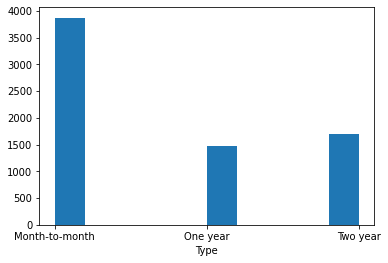

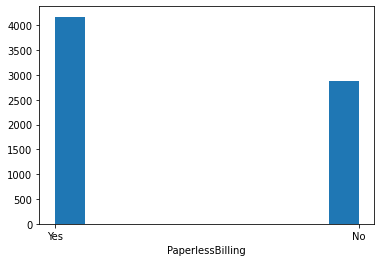

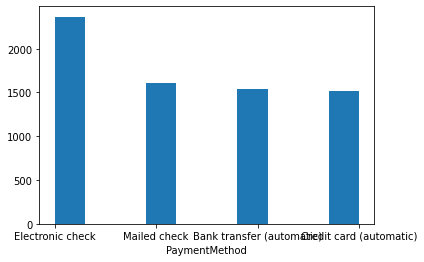

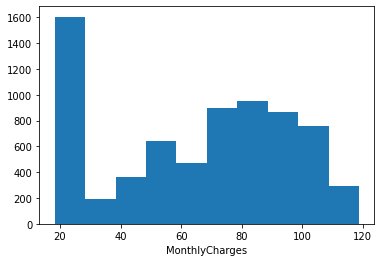

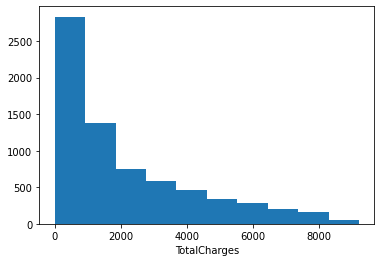

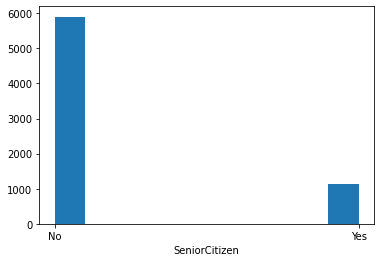

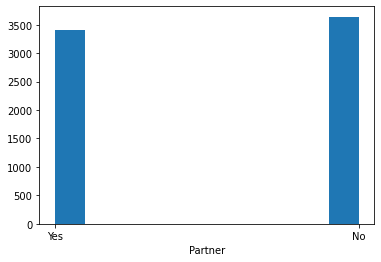

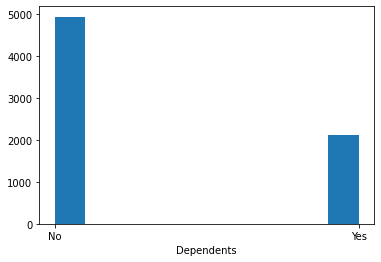

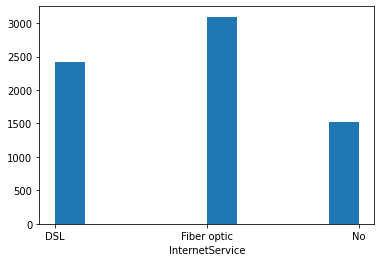

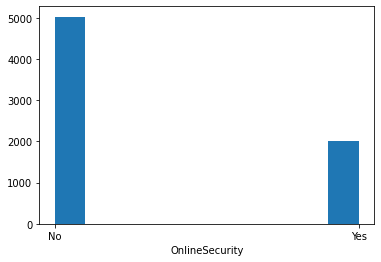

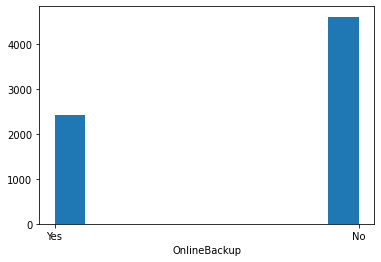

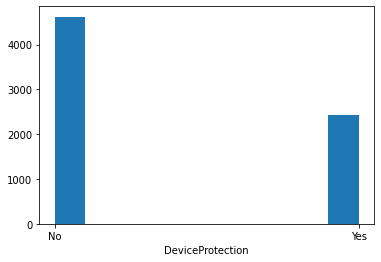

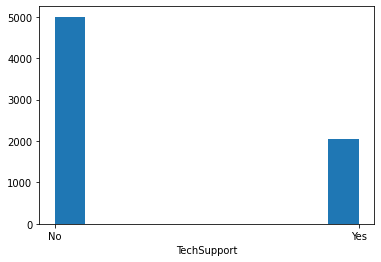

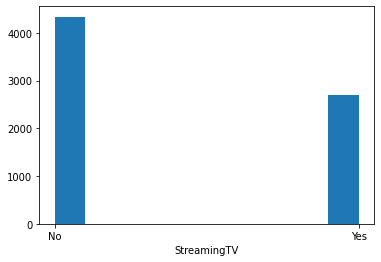

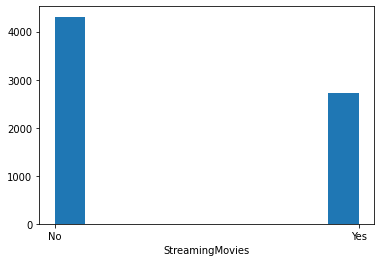

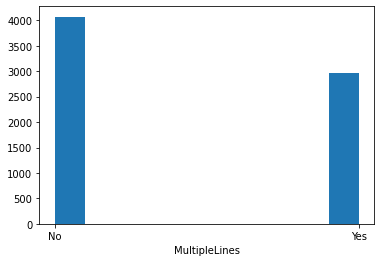

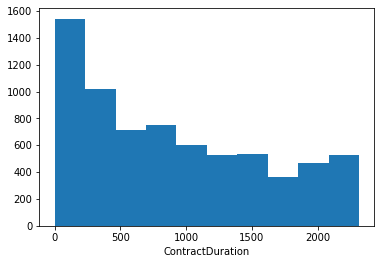

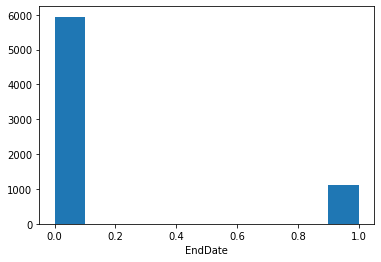

In [24]:
for col in df.columns:
    plt.hist(df[col])
    plt.xlabel(col)
    plt.show()

In [25]:
#Исследую корреляцию. Другим способом
df = df.apply(
        lambda x: x.astype("category") if x.dtype == "O" else x)
cramersv = am.CramersV(df) 
cramersv.fit()

,Type,PaperlessBilling,PaymentMethod,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,EndDate
Type,1.000000,0.177645,0.266655,0.143868,0.296039,0.244212,0.206921,0.251459,0.164591,0.227840,0.296463,0.112316,0.116646,0.109925,0.156616
PaperlessBilling,0.177645,1.000000,0.248719,0.156530,0.014877,0.111377,0.378427,0.003636,0.126735,0.103797,0.037880,0.223841,0.211716,0.163530,0.054869
PaymentMethod,0.266655,0.248719,1.000000,0.195985,0.162762,0.150744,0.313123,0.176022,0.189107,0.205498,0.182162,0.253325,0.254491,0.227446,0.144079
SeniorCitizen,0.143868,0.156530,0.195985,1.000000,0.016479,0.211185,0.265324,0.038653,0.066572,0.059428,0.060625,0.105378,0.120176,0.142948,0.056724
Partner,0.296039,0.014877,0.162762,0.016479,1.000000,0.452676,0.000907,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412,0.142057,0.146447
Dependents,0.244212,0.111377,0.150744,0.211185,0.452676,1.000000,0.180267,0.080972,0.023671,0.013963,0.063268,0.016558,0.039741,0.024526,0.032564
InternetService,0.206921,0.378427,0.313123,0.265324,0.000907,0.180267,1.000000,0.394126,0.381838,0.380757,0.391367,0.442979,0.442924,0.368870,0.095433
OnlineSecurity,0.251459,0.003636,0.176022,0.038653,0.143106,0.080972,0.394126,1.000000,0.283832,0.275438,0.354931,0.176207,0.187398,0.098108,0.085921
OnlineBackup,0.164591,0.126735,0.189107,0.066572,0.141498,0.023671,0.381838,0.283832,1.000000,0.303546,0.294233,0.282106,0.274501,0.202237,0.148288
DeviceProtection,0.227840,0.103797,0.205498,0.059428,0.153786,0.013963,0.380757,0.275438,0.303546,1.000000,0.333313,0.390874,0.402111,0.201137,0.141059


Тут есть признаки, имеют которые слишком сильную корреляцию с друг другом или же, слишком низкую корреляцию с целевым показателем, их необходимо удалить

In [26]:
df = df.drop(['Dependents'],axis = 1)
df = df.drop(['TechSupport'],axis = 1)
df = df.drop(['PaymentMethod'],axis = 1)
df = df.drop(['StreamingMovies'],axis = 1)
df = df.drop(['OnlineSecurity'],axis = 1)
df = df.drop(['InternetService'],axis = 1)
df = df.drop(['SeniorCitizen'],axis = 1)

## Создание модели

In [27]:
#Разделяю данные
target = df['EndDate']
features = df.drop(['EndDate'], axis = 1)
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size = 0.25, random_state = RANDOM_STATE)

In [28]:
#Произвожу трансформацию
ohe_train_features = train_features.select_dtypes(include='category').columns.to_list()
num_features = train_features.select_dtypes(exclude='category').columns.to_list()

encoder_ohe = OneHotEncoder(drop = 'first', handle_unknown='ignore', sparse=False)
train_features_e = train_features.copy()
train_target = train_target.copy()
encoder_ohe.fit(train_features_e[ohe_train_features])
train_features_e[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(train_features_e[ohe_train_features])
train_features_e = train_features_e.drop(ohe_train_features, axis=1)


scaler = StandardScaler()
train_features_e[num_features] = scaler.fit_transform(train_features_e[num_features])


In [29]:
#Тестирую древо
model_tree = DecisionTreeClassifier(random_state = RANDOM_STATE)
param_grid_tree = {
    'criterion':['gini','entropy'],
    'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
gs_tree = GridSearchCV(
    model_tree, 
    param_grid=param_grid_tree, 
    scoring='roc_auc', 
    n_jobs=-1
)
gs_tree.fit(train_features_e, train_target)

print(f'best_score: {gs_tree.best_score_}')
print(f'best_params: {gs_tree.best_params_}')

best_score: 0.7872251075214824
best_params: {'criterion': 'entropy', 'max_depth': 6}


In [30]:
#Тестирую лес
model_forest = RandomForestClassifier(random_state=RANDOM_STATE)

param_grid_forest = [
    {'max_depth':[None,2,5,10,20], 'n_estimators':[64, 128, 256]}
]

gs_forest = GridSearchCV(
    model_forest, 
    param_grid=param_grid_forest, 
    scoring='roc_auc', 
    n_jobs=-1
)

gs_forest.fit(train_features_e, train_target)


print(f'best_score: {gs_forest.best_score_}')
print(f'best_params: {gs_forest.best_params_}')

best_score: 0.8174837295685444
best_params: {'max_depth': 10, 'n_estimators': 128}


In [31]:
# тестирую лог.регрессию
model_log = LogisticRegression(random_state=RANDOM_STATE)


param_grid_log = [{'penalty':['l1','l2','none'], 
              'C':[0.001, 0.01, 0.1, 1, 10, 100]}]

gs_log = GridSearchCV(
    model_log, 
    param_grid=param_grid_log, 
    scoring='roc_auc', 
    n_jobs=-1
)

gs_log.fit(train_features_e, train_target)


print(f'best_score: {gs_log.best_score_ }')
print(f'best_params: {gs_log.best_params_}')

best_score: 0.7543300102835269
best_params: {'C': 1, 'penalty': 'l2'}


In [32]:
# тестирую catboost
model_cboost = CatBoostClassifier(random_state = RANDOM_STATE,logging_level='Silent')
param_grid_cboost = {'depth':[3,1,6,4,5,7],
          'learning_rate':[0.01,0.1,0.2], 
                    }
gs_cboost = GridSearchCV(
    model_cboost, 
    param_grid=param_grid_cboost, 
    scoring='roc_auc', 
    n_jobs=-1
)
gs_cboost.fit(train_features_e, train_target)
print(f'best_score: {gs_cboost.best_score_ }')
print(f'best_params: {gs_cboost.best_params_}')

best_score: 0.9159261329834134
best_params: {'depth': 3, 'learning_rate': 0.2}


Я сделал выбор, я буду проводить финальный тест на catboost

## Финальный тест

In [33]:
#Произвожу трансформацию тестовой выборки
test_features[
    encoder_ohe.get_feature_names()
] = encoder_ohe.transform(test_features[ohe_train_features])

test_features = test_features.drop(ohe_train_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОЙ ВЫБОРКЕ, масштабируем тестовую
test_features[num_features] = scaler.transform(
    test_features[num_features]
)


In [40]:
#Финальный тест
model_cboost = CatBoostClassifier(random_state = RANDOM_STATE,logging_level='Silent',depth = 3, learning_rate =0.2)
model_cboost.fit(train_features_e, train_target)
predictions = model_cboost.predict(test_features)
probs = model_cboost.predict_proba(test_features)
print('auc-roc: ',roc_auc_score(test_target,probs[:, 1]),'accuracy:',model_log.score(test_features,test_target))

auc-roc:  0.9371547965116279 accuracy: 0.8745031232254401


In [41]:
#Произвожу тест на адекватность
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(train_features_e, train_target)
dummy_predictions = dummy_model.predict(test_features)
print(roc_auc_score(test_target,dummy_predictions))

0.5


Результат удовлетворительный

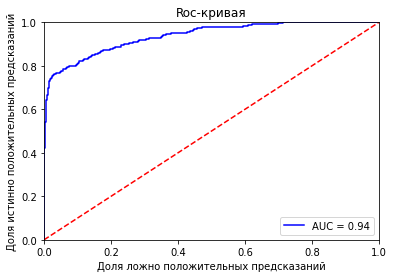

In [42]:
#рисую
fpr, tpr, threshold = metrics.roc_curve(test_target, probs[:, 1])
roc_auc = metrics.auc(fpr, tpr)
plt.title('Roc-кривая')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Доля истинно положительных предсказаний')
plt.xlabel('Доля ложно положительных предсказаний')
plt.show()

In [43]:
print('Матрица ошибок\n',confusion_matrix(test_target, predictions))

Матрица ошибок
 [[1485   20]
 [  76  180]]


In [44]:
print('Распределение признаков, в зависимости от их важности')
perm = PermutationImportance(model_cboost, random_state=RANDOM_STATE).fit(test_features, test_target)
eli5.show_weights(perm, feature_names = test_features.columns.tolist())

Распределение признаков, в зависимости от их важности


Weight,Feature
0.3094 ± 0.0219,ContractDuration
0.2158 ± 0.0138,TotalCharges
0.0184 ± 0.0041,x0_Two year
0.0132 ± 0.0070,MonthlyCharges
0.0057 ± 0.0023,x0_One year
0.0022 ± 0.0017,x6_Yes
0.0016 ± 0.0032,x3_Yes
0.0011 ± 0.0010,x4_Yes
0.0010 ± 0.0025,x2_Yes
-0.0006 ± 0.0016,x5_Yes


## Финальный вывод

В данном выпускном проекте я создал модель, которая предсказывает уход клиента.
Моя работа состояла из нескольких этапов:
1. Провёл исследование столбцов, выявил связи и закономерности между ними
2. Объединил четыре столбцов в один, и привёл его в формат, пригодный для обучения
3. Протестировал 3 модели и по два гиперпараметра на каждую(А ещё бустинг хотел потестировать)
4. Провёл финальное тестирование, и получил результат в 85 AUC-RUC и 95 accuracy, нарисовал auc-кривую, построил матрицу ошибок и график полезности признаков(я не знаю зачем) 

## Итоговый отчёт

Ключевые тезисы:
1. Все части плана были исполнены.
2. Фрагмент с исследовательским анализом данных оказался сложнее чем я расчитывал, ввиду непривычной мне структуры данных, которая заключаласть в четырёх изначальных датасетах, которые содержали большое количество признаков разных типов, форматов, и количеством строк
3. Структура плана оказалась верной, каждая последующая часть цепляется за предыдущую, и вносит свой вклад в выполнение поставленой задачи. Первый и второй пункт можно объединить, но это не принципиально.
4. Цель проекта я считаю выполненой: Я получил модель, которая предсказывает уход клиента и имеет показатель auc-roc в 0.94 

В ходе проекта было использованно:
1. Предобработка: Стандартная гисторграмма для изучения распределения, корреляция Краммера для получения корреляции категориальных признаков, Ohe encoder и standart scaler для кодировки и стандартизации соответсвенно, эти два компонента были использованны для приведения данных в формат, подходящий для обучения.
2. Анализ моделей: тут я тестировал четыре модели: лог.регрессию, древо решений, рандомный лес и catboost.
3. Финальный тест: dummy_classifier для теста на адекватность, matplotlib для иллюстрации roc-кривой и eli5 для изучения важности признаков.

Также стоит отметить:
1. Все части проекта необходимы для корректной работы финальной модели. Наиболее важной частью я считаю предобработку, тк она очень сильно влияет на точность предсказаний, и приводит данные в формат, пригодный для работы.
2. Гиперпараметры модели catboost: {'depth': 3, 'learning_rate': 0.2, random_state = 120623}. При необходимости, возможно подключение допольнительных вычислительных мощностей для более обширного подбора.

Трудности, с которыми я столкнулся: 
1. Предобработка данных и необходимость приведения большого количество самых разных столбцов к пригоднуму формату
2. Подбор модели, во время которого мне приходилось много раз изменять параметры grid_search ради приемлимого времени обучения и точности

Иллюстрации:
Roc-кривая
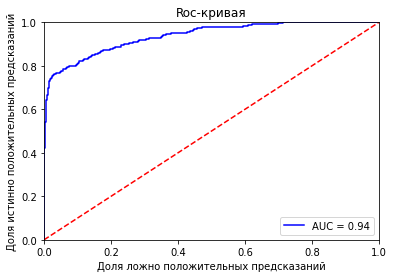



Матрица ошибок

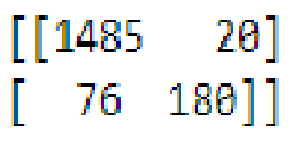